In [101]:
# | default_exp attention

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TOKENIZERS_PARALLELISM=false


# Attention based modules


References:
- https://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture09-transformers.pdf

Technical evolutions:
 
- https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Getting_the_most_out_of_LLMs.ipynb

In [102]:
# | export
import os
from typing import Optional
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from dataclasses import dataclass
from my_transformer.utils import save_model, load_model
from my_transformer.tokenizers import BPETokenizer

from torch.utils.tensorboard import SummaryWriter
import math
from tqdm import tqdm

In [125]:
from icecream import ic
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
import warnings
from torch.jit import TracerWarning

warnings.filterwarnings("ignore", category=TracerWarning)

In [104]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
g = torch.Generator(device=device).manual_seed(42)

## Attention mechanism
Based on formal algorithm for transformers (https://arxiv.org/abs/2207.09238) where it can be used for different attention architectures like 
- encoder-decoder/seq-to-seq (very first transformer), 
- encoder-only (bert), 
- decoder-only (gpt-*, gopher). 

### Encoder-decoder architecture use 2 sequences as input
- context sequence of tokens (z), which is used to encode context as a vector per token with bidirectional attention
- primary sequence of tokens (x), which is used to decode both the encoded context and a masked primary sequence (tokens in primary sequence that precedes current). This is used to train a translator from FR to EN for instance. FR tokens are the context sequence and EN tokens are the primary sequence (target)
 
### Encoder only architecture use 1 primary sequence as input
Given a primary input sequence (x) with some tokens masked out, the goal is to recover the masked tokens. the goal is to learn a generally usefull representation of text. Uses a bidirectional attention

### Decoder only architecture use 1 primary sequence as input
Autoregressive language modelling where the goal is to predict the next token of a primary token sequence (x). Uses a unidirectional causal (masked) attention. 

## Basic mechanism behind attention
How can we compute a matrix of size TxT (T is nb timesteps or length) to split attention from each token in sequence to only previouse tokens

That matrix would be called attention matrix

In [105]:
torch.manual_seed(42)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [106]:
# 1st method to compute the matrix
wei = torch.tril(torch.ones((T, T)))
ic(wei)
wei = wei / wei.sum(axis=1, keepdim=True)
ic("weight", wei)
xbow = wei @ x  # B,T,C @ B,T,T ---> B,T,C

ic| wei: tensor([[1.,

 0., 0., 0., 0., 0., 0., 0.],
                 [1., 1., 0., 0., 0., 0., 0., 0.],
                 [1., 1., 1., 0., 0., 0., 0., 0.],
                 [1., 1., 1., 1., 0., 0., 0., 0.],
                 [1., 1., 1., 1., 1., 0., 0., 0.],
                 [1., 1., 1., 1., 1., 1., 0., 0.],
                 [1., 1., 1., 1., 1., 1., 1., 0.],
                 [1., 1., 1., 1., 1., 1., 1., 1.]])
ic| "weight": 'weight'
    wei: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
                 [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
                 [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        

In [107]:
# method 2 using softmax
tril = torch.tril(torch.ones((T, T)))
ic(tril)
# we can initiate with zeros, ones or any values
wei = torch.zeros((T, T))
#
wei = torch.ones((T, T))
wei = torch.full((T, T), 4.0)

# ic(wei)
wei = wei.masked_fill(tril == 0, value=float("-inf"))
ic(wei)
wei = F.softmax(wei, dim=1)
ic(wei)

xbow2 = wei @ x
torch.allclose(xbow, xbow2)

ic| tril: tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
                  [1., 1., 0., 0., 0., 0., 0., 0.],
                  [1., 1., 1., 0., 0., 0., 0., 0.],
                  [1., 1., 1., 1., 0., 0., 0., 0.],
                  [1., 1., 1., 1., 1., 0., 0., 0.],
                  [1., 1., 1., 1., 1., 1., 0., 0.],
                  [1., 1., 1., 1., 1., 1., 1., 0.],
                  [1., 1., 1., 1., 1., 1., 1., 1.]])
ic| wei: tensor([[4., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
                 [4., 4., -inf, -inf, -inf, -inf, -inf, -inf],
                 [4., 4., 4., -inf, -inf, -inf, -inf, -inf],
                 [4., 4., 4., 4., -inf, -inf, -inf, -inf],
                 [4., 4., 4., 4., 4., -inf, -inf, -inf],
                 [4., 4., 4., 4., 4., 4., -inf, -inf],
                 [4., 4., 4., 4., 4., 4., 4., -inf],
                 [4., 4., 4., 4., 4., 4., 4., 4.]])
ic| wei: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.5000, 0.5000, 0

True

### Let put it together

- we project the input (x) to a 
  - query: current element we focus on
  - key: context (other words)
  - value : 
- we compute similarity with dot product between query and key, to capture how similar current element and context are aligned/similar, aka raw attention score
- we mask the score matrix so each query focus only on past tokens (key)
- we normalize the similarity score with a softmax -> it compute the weight each token should put on previous tokens.
- apply the attention matrix (weight) to the value matrix. 


ic| B: 1, T: 8, C: 5
ic| wei.shape: torch.Size([1, 8, 8])
    v.shape: torch.Size([1, 8, 5])
    out.shape: torch.Size([1, 8, 5])
ic| wei[0]: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.4967, 0.5033, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.3345, 0.3286, 0.3369, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.2571, 0.2444, 0.2441, 0.2544, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.1978, 0.1931, 0.2006, 0.2130, 0.1955, 0.0000, 0.0000, 0.0000],
                    [0.1666, 0.1617, 0.1675, 0.1753, 0.1628, 0.1661, 0.0000, 0.0000],
                    [0.1391, 0.1407, 0.1470, 0.1503, 0.1398, 0.1403, 0.1428, 0.0000],
                    [0.1232, 0.1230, 0.1296, 0.1297, 0.1201, 0.1202, 0.1258, 0.1285]],
                   grad_fn=<SelectBackward0>)


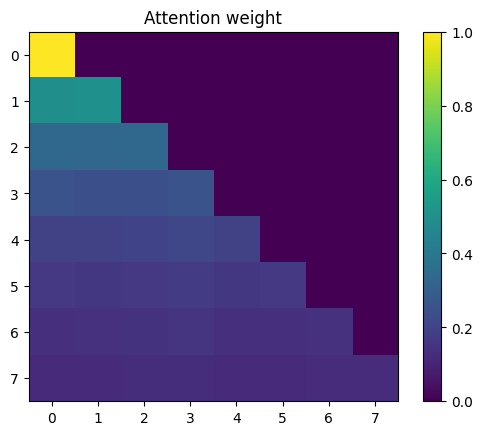

In [108]:
torch.manual_seed(42)
B, T, C = 1, 8, 5
ic(B, T, C)
# the input after token embedding lookup
x = torch.rand(B, T, C)

head_size = 5
key = nn.Linear(C, head_size)
k = key(x)
query = nn.Linear(C, head_size)
q = query(x)
value = nn.Linear(C, head_size)
v = value(x)
# v = torch.full((B,T,C), fill_value=1.)

# dot product as a similarity measure
wei = q @ k.transpose(-2, -1) * head_size**-0.5
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)

out = wei @ v
ic(wei.shape, v.shape, out.shape)
ic(wei[0])

plt.imshow(wei[0].detach())
plt.colorbar()
plt.title("Attention weight")
plt.show()


# first token out value should be the same as first value
assert all(out[0][0] == v[0][0])
# then it's no more the case
assert not all(out[0][3] == v[0][3])

## Let write torch modules and functions

In [109]:
# | export
def unidirectional_mask(seq_len: int) -> torch.Tensor:
    # inverse_mask = torch.triu(torch.ones((1, seq_len, seq_len)), diagonal=1)  # .type(torch.uint8)
    # inverse_mask = torch.tril(torch.ones((T, T)))
    # ic(inverse_mask)
    # tmask = inverse_mask == 0
    # ic(tmask)
    mask = torch.tril(torch.ones((1, seq_len, seq_len)))
    return mask

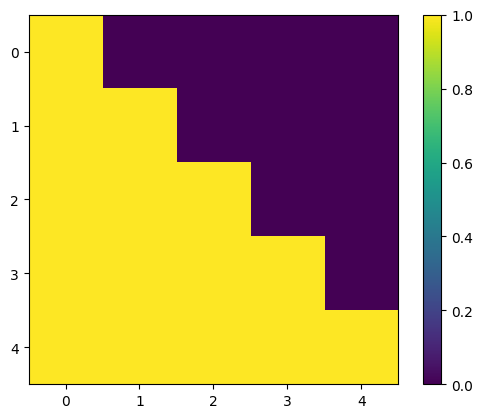

In [110]:
ic.disable()
ic.enable()
mask = unidirectional_mask(5)

plt.imshow(mask[0])
plt.colorbar()

plt.show()

In [121]:
# | export
def attention(
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
    softmax: torch.nn.Module = nn.Softmax(dim=-1),
    dropout: Optional[torch.nn.Module] = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    """compute multi-head attention weigths and attention weights applied to value tensor.

    Arguments:
        query -- query tensor in batch_size, head_nb, seq_len, d_k shape
        key -- same shape structure as query
        value -- same shape structure as query
        mask -- mask of tokens (default: {None})
        softmax -- softmax module (default: {nn.Softmax(dim=-1)})
        dropout -- dropout ratio (default: {None})

    Returns:
        attention -- attention weight applied to value
        attn-weights
    """
    # d_k is the size of atttention per head (=d//nb heads, where d is the size of attn model)
    # IT SHOULD BE, batch_size, head_nb, seq_len , d_k
    batch_size, head_nb, seq_len, d_k = query.shape

    scores = (query @ key.transpose(-2, -1)) * (d_k**-0.5)
    if mask is not None:
        # mask scores with -inf when mask is False. If we masked_fill(mask, -inf), it would mask when mask ==1 (is true). We want to mask when it's 0 (false).
        scores = scores.masked_fill(mask == 0, float("-inf"))
    attn_weights = softmax(scores)  # , dim=-1)
    if dropout is not None:
        attn_weights = dropout(attn_weights)

    atn = attn_weights @ value
    # ic(atn.shape, attn_weights.shape, value.shape)
    assert torch.all(
        torch.eq(atn.shape, query.shape)
    ), f"atn shape {atn.shape} should be the same as input tensors key, query and value shapes. Query shape: {query.shape}"
    return atn, attn_weights

In [122]:
seq_len = 4
embedding_dim = 5
h = 1  # nb of heads
d_k = embedding_dim // h
batch_size = 1
# shape is batch, h, seq_len, d_k
Q = torch.randn((batch_size, h, seq_len, d_k), generator=g, device=device, requires_grad=True)
K = torch.randn((batch_size, h, seq_len, d_k), generator=g, device=device, requires_grad=True)
V = torch.randn((batch_size, h, seq_len, d_k), generator=g, device=device, requires_grad=True)
mask = unidirectional_mask(seq_len).to(device)

ic.disable()
ic.enable()
attn, attn_weight = attention(Q, K, V, mask=mask, softmax=torch.nn.Softmax(dim=-1), dropout=torch.nn.Dropout(0.0))
attn_no_mask, attn_weight_no_mask = attention(Q, K, V, dropout=torch.nn.Dropout(0.0))
sum_attn_w = attn_weight.sum(dim=-1)
assert torch.isclose(sum_attn_w, torch.ones_like(sum_attn_w), atol=0.001).all()

### attention vizualization

we see that masked attention weight is a matrix where upper diagonal is 0. But attention (attention weight applied to value), is a weighted sum of values at each time step. It takes only current and previous steps (so values are not masked, only the weights are masked)

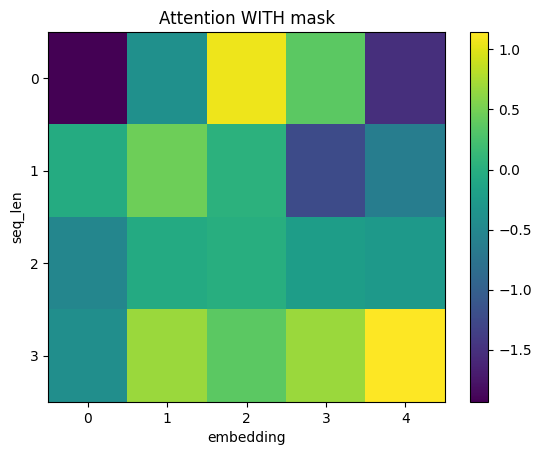

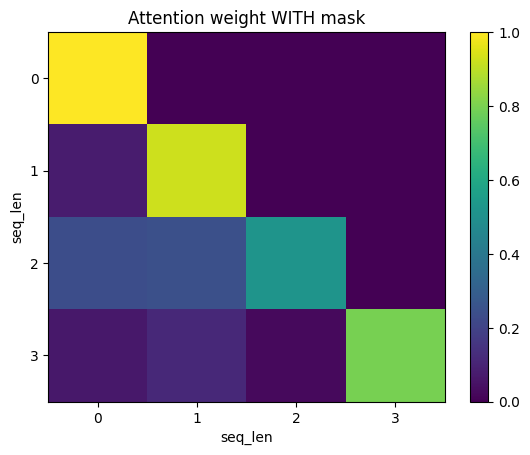

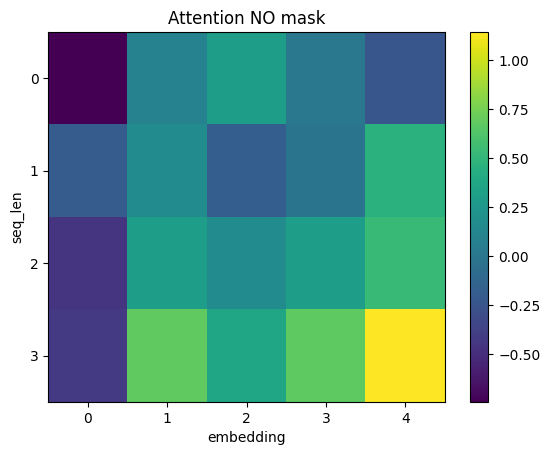

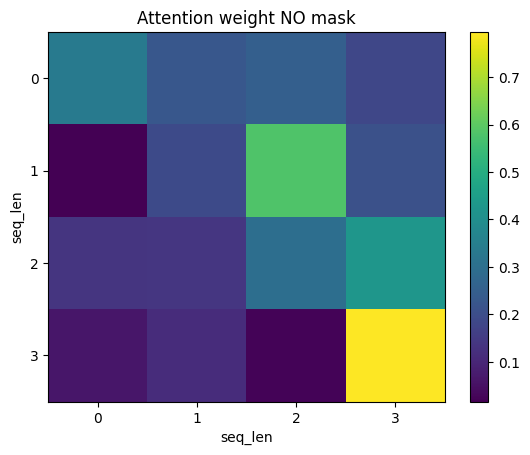

In [132]:
def display_matrix(m: torch.Tensor, title: str = "Matrix", x_label: str = "", y_label: str = ""):
    np_m = m.cpu().detach()

    plt.imshow(np_m, aspect="auto")
    plt.yticks(range(np_m.shape[0]), range(np_m.shape[0]))
    plt.xticks(range(np_m.shape[1]), range(np_m.shape[1]))
    plt.xlabel(x_label)  # Add name to the X-axis
    plt.ylabel(y_label)
    plt.colorbar()
    plt.title(title)
    plt.show()


display_matrix(attn[0][0], title="Attention WITH mask", x_label="embedding", y_label="seq_len")
display_matrix(attn_weight[0][0], title="Attention weight WITH mask", x_label="seq_len", y_label="seq_len")

display_matrix(attn_no_mask[0][0], title="Attention NO mask", x_label="embedding", y_label="seq_len")
display_matrix(attn_weight_no_mask[0][0], title="Attention weight NO mask", x_label="seq_len", y_label="seq_len")

In [114]:
# | export


class MultiHeadAttention(nn.Module):
    """Multihead attention module as defined in Formal algorithm for transformers (https://arxiv.org/abs/2207.09238)
    It can be used for different attention architectures like encoder-decoder/seq-to-seq (very first transformer),
    encoder-only (bert), decoder-only (gpt-*, gopher).

    It splits weights into h heads.
    """

    def __init__(self, d: int, h: int, dropout: float = 0.0, bias: bool = True):
        """_summary_

        Arguments:
            d -- dimension of hidden state (aka model dimension)
            h -- nb of heads

        Keyword Arguments:
            dropout -- dropout rate (default: {0.0})
            bias -- do we include bias in linear computations (default: {True})
        """
        super().__init__()
        self.d = d
        self.h = h
        assert (
            d % h == 0
        ), f"Model dim {d} must be a multiple of nb of heads {h}. d_k {d//h} is the model dim per head, because we split by nb of heads."
        self.d_k = d // h  # model dim on one head.
        self.wq = nn.Linear(d, d, bias=bias)
        self.wk = nn.Linear(d, d, bias=bias)
        self.wv = nn.Linear(d, d, bias=bias)
        self.wo = nn.Linear(d, d, bias=bias)  # linear projection of output matrix.
        self.dropout = nn.Dropout(dropout)

    def forward(
        self, x: torch.Tensor, z: torch.Tensor, mask: Optional[torch.Tensor] = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """_summary_

        Args:
            x (torch.Tensor): primary sequence
            z (torch.Tensor): context sequence, only for encoder-decoder architecture.
            mask (torch.Tensor, optional): _description_. Defaults to None.
        """

        batch_size, seq_len, d = x.size()
        if z is None:
            # in decoder only context is the primary sequence.
            z = x
        q = self.wq(x)
        k = self.wk(z)
        v = self.wk(z)
        # shape has to be batch, h, seq_len, d_k (d//h)
        # first view to : batch,seq_len,h,d_k , then transpose h and seq_len so we got per head q,k,v
        q = q.view(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)

        # attention has to be done on each head.
        mh_attn, mh_attn_weight = attention(q, k, v, mask=mask, dropout=self.dropout)
        assert mh_attn_weight.size == (batch_size, self.h, seq_len, seq_len)
        # we need to create a contiguous memory space for tensor after transpose so we can apply view.
        concat_attn = mh_attn.transpose(2, 1).contiguous().view(batch_size, seq_len, self.h * self.d_k)
        concat_attn_weight = torch.sum(mh_attn_weight, dim=1)
        assert concat_attn.size() == (batch_size, seq_len, d)
        # apply linear layer on concatenated attention.
        output = self.dropout(self.wo(concat_attn))
        return output, concat_attn_weight

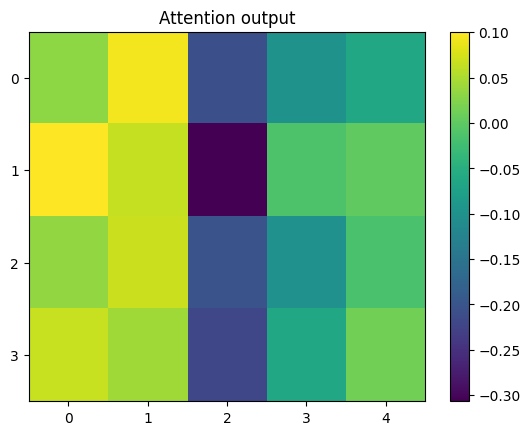

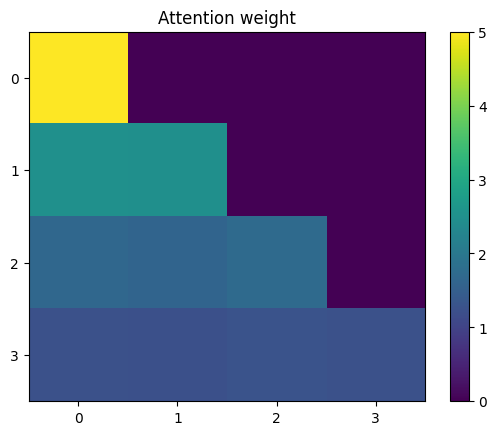

In [141]:
batch_size = 2
primary_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
ctx_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)

mh = MultiHeadAttention(d=embedding_dim, h=5, dropout=0.0, bias=False).to(device)
mh_attn, mh_attn_weight = mh(primary_seq, ctx_seq, mask=mask)

display_matrix(mh_attn[0], title="Attention output")
display_matrix(mh_attn_weight[0], title="Attention weight")

### torch MultiheadAttention implementation

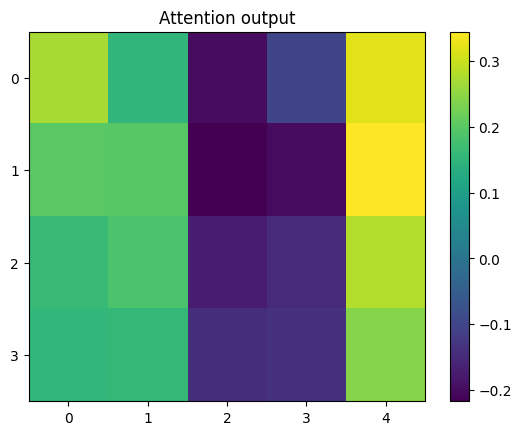

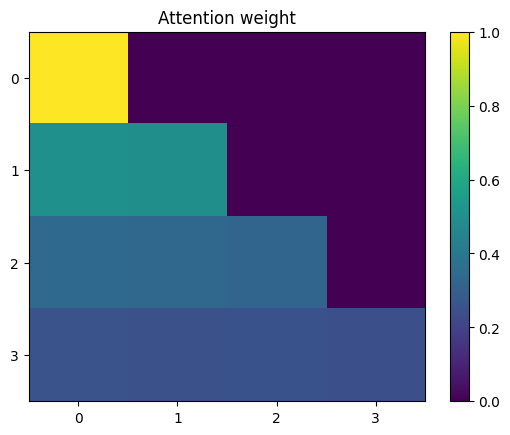

In [140]:
# test with multihead_attn = nn.MultiheadAttention(embed_dim, num_heads) so that result is the same.
# the graph output should look the same, even if they are not exactly the same due to different initialization

nn_mh = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=5, dropout=0.0, batch_first=True, bias=False).to(
    device
)
nn_mh_atn, nn_mh_atn_weights = nn_mh(primary_seq, ctx_seq, ctx_seq, attn_mask=mask[0] == 0)


display_matrix(nn_mh_atn[0], title="Attention output")
display_matrix(nn_mh_atn_weights[0], title="Attention weight")

## Layer normalization

My own implementation of layer normalization. To be compared with torch one.

In [147]:
# | export
class LayerNormalization(nn.Module):
    def __init__(self, d: int, eps: float = 1e-05) -> None:
        super().__init__()
        self.d = d
        self.eps = eps
        self.gamma = torch.nn.Parameter(torch.ones(d, dtype=torch.float))  # scale
        self.beta = torch.nn.Parameter(torch.zeros(d, dtype=torch.float))  # offset

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # normalization across features (independently) for each sample. We compute mean and var on the last 2 axis, so we have it per sampel
        mean = x.mean((-1), keepdim=True)  # .unsqueeze(-1)
        # pytorch use welford method (with unbiased=False) which is numerically more robust for small differences and edge cases
        var = x.var((-1), unbiased=False, keepdim=True)
        x_hat = torch.mul(((x - mean) / torch.sqrt(var + self.eps)), self.gamma) + self.beta

    return x_hat

In [148]:
# check implement is close to pytorch one.
torch.manual_seed(0)
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
x = torch.tensor([[[2, 1, 1, 1, 1], [2, 2, 2, 2, 1]]], dtype=torch.float).to(device)
layer_norm = LayerNormalization(d=embedding_dim, eps=1e-05, use_torch_implem=False).to(device)
x_hat = layer_norm(x)

torch_x_hat = F.layer_norm(
    x, normalized_shape=[embedding_dim], weight=torch.ones(embedding_dim, dtype=torch.float, device=device), eps=1e-05
)
assert torch.allclose(x_hat, torch_x_hat), "my implementation and torch should be close"
x_hat, torch_x_hat

(tensor([[[ 1.9999, -0.5000, -0.5000, -0.5000, -0.5000],
          [ 0.5000,  0.5000,  0.5000,  0.5000, -1.9999]]], device='mps:0',
        grad_fn=<AddBackward0>),
 tensor([[[ 1.9999, -0.5000, -0.5000, -0.5000, -0.5000],
          [ 0.5000,  0.5000,  0.5000,  0.5000, -1.9999]]], device='mps:0'))

## Decoder transformer

Architecture used by GPT-*, Gopher, where it want to predict the next token given previous ones. Uses a mask to make attention causal.

In [149]:
# | export


class DecoderTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int,
        model_size: int,
        nb_heads: int = 1,
        nb_layers: int = 1,
        dropout: float = 0.0,
        bias: bool = True,
    ) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.tok_emb = nn.Embedding(vocab_size, embedding_dim=model_size)
        self.pos_enc = PositionalEncoder(
            max_seq_len=max_seq_len, embedding_dim=model_size, dropout=dropout, is_learned=True
        )
        self.layers = nn.Sequential(
            *[
                DecoderLayer(model_size=model_size, nb_heads=nb_heads, dropout=dropout, bias=bias)
                for i in range(nb_layers)
            ]
        )
        self.layer_norm = LayerNormalization(model_size)
        self.unembedding = nn.Linear(model_size, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, l = x.size()
        emb = self.tok_emb(x)
        x = self.pos_enc(emb)
        mask = unidirectional_mask(seq_len=l).to(x.device)
        for layer in self.layers:
            x = layer(x, mask)
        x = self.layer_norm(x)
        logits = self.unembedding(x)
        return logits

    def generate(self, x: torch.Tensor, max_new_tokens: int):
        for i in range(max_new_tokens):
            # we take at most max_seq_len tokens
            x_block = x[:, -self.max_seq_len :]
            logits = self(x_block)
            # we take the logit for last token, used to predict token.
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            tok_next = torch.multinomial(probs, num_samples=1)
            x = torch.cat((x, tok_next), dim=1)
        return x

In [120]:
def print_model_size(model: nn.Module):
    print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


dec = DecoderTransformer(vocab_size=6, max_seq_len=5, model_size=10, nb_heads=1).to(device)
print_model_size(dec)
x = torch.tensor([[0, 1, 2, 3, 4], [1, 2, 3, 4, 5]], dtype=torch.int, device=device)
y_hat = dec(x)
y_hat.shape


target = torch.rand(*y_hat.shape).to(device)
ic(target.shape, y_hat.shape)
loss = nn.CrossEntropyLoss()
loss = loss(y_hat, target)
loss.retain_grad()
y_hat.retain_grad()
loss


input = torch.zeros((3, 1), dtype=torch.long, device=device)
dec.generate(input, max_new_tokens=16)

NameError: name 'PositionalEncoder' is not defined

## Training and dataset

In [ ]:
# with open("../dataset/shakespeare.txt") as f:
#    text = f.read()

df = pd.read_csv("../dataset/bob_dylan_lyrics.csv")
text = "\n\n".join(df.lyrics.values.tolist())

In [ ]:
def train_tokenizer(text: str, vocab_size: int = 1000) -> Tokenizer:
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["[PAD]", "[UNK]"])  # pad is 0, unk is 1
    tokenizer.train_from_iterator([text], trainer=trainer)
    tokenizer.decoder = decoders.ByteLevel()
    return tokenizer


vocab_size = 1000
tokenizer = train_tokenizer(text, vocab_size=vocab_size)
sent_to_encode = "How does it feel to be on your own !"
encodings = tokenizer.encode(sent_to_encode)
encodings.ids, tokenizer.decode(encodings.ids)

In [ ]:
class BPEDataset(Dataset):
    def __init__(self, text: str, mode: str = "train", seq_len: int = 20, vocab_size: int = 1000, device: str = "cpu"):
        assert mode in ["train", "test"], "Mode must be 'train' or 'test'"
        self.mode = mode
        self.device = device
        self.seq_len = seq_len
        self.text = text

        words = text.split(" ")
        train_pos = math.ceil(len(words) * 0.8)
        train_words = words[:train_pos]
        test_words = words[train_pos:]
        self.train_txt = " ".join(train_words[:])
        self.test_txt = " ".join(test_words[:])
        self.tokenizer = train_tokenizer(self.train_txt, vocab_size=vocab_size)
        train_encoding = self.tokenizer.encode(self.train_txt)
        test_encoding = self.tokenizer.encode(self.test_txt)
        self.train_encoded = torch.tensor(train_encoding.ids, dtype=torch.long, device=device)
        self.test_encoded = torch.tensor(test_encoding.ids, dtype=torch.long, device=device)

    def __len__(self):
        if self.mode == "train":
            data = self.train_encoded
        else:
            data = self.test_encoded
        return len(data) // self.seq_len

    def __getitem__(self, idx):
        if self.mode == "train":
            data = self.train_encoded
        else:
            data = self.test_encoded

        data_len = data.shape[0]
        i = idx * self.seq_len
        if i >= data_len:
            raise ValueError(f"idx {idx} bigger than {self.mode} data length {data_len}")
        x = data[i : i + self.seq_len]
        y = data[i + 1 : i + self.seq_len + 1]
        return x, y

In [ ]:
torch.manual_seed(1337)
device = "mps"

batch_size = 64  # how many independent sequences will we process in parallel?
seq_len = 256  # what is the maximum context length for predictions?
vocab_size = 5000
model_size = 384
num_heads = 6
num_layers = 6
dropout = 0.2
model_version = f"t{vocab_size}_0.5"

train_ds = BPEDataset(text, mode="train", seq_len=seq_len, vocab_size=vocab_size, device=device)
test_ds = BPEDataset(text, mode="test", seq_len=seq_len, vocab_size=vocab_size, device=device)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

model = DecoderTransformer(
    vocab_size=vocab_size,
    max_seq_len=seq_len,
    model_size=model_size,
    nb_heads=num_heads,
    nb_layers=num_layers,
    dropout=dropout,
).to(device)
xb, yb = next(iter(test_dl))
train_logit = model(xb)
train_logit.shape

print(f"""cross entropy of logit of non-trained model should be the about the same as cross entropy of uniform distrib across all tokens: 
      {F.cross_entropy(train_logit.view(batch_size * seq_len, vocab_size), yb.view(batch_size * seq_len)).item()}, 
      {(-torch.log(torch.tensor(1)/torch.tensor(vocab_size))).item()}""")
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

In [ ]:
class EpochTrainer:
    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        train_dl: DataLoader,
        test_dl: DataLoader,
        model_version: str,
        model_name: str,
        nb_epochs: int = 100,
        loss_fn=F.cross_entropy,
        do_save_model: bool = True,
        save_every_epoch_nb: int = 20,
        device: str = "cpu",
    ) -> None:
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.nb_epochs = nb_epochs
        self.do_save_model = do_save_model
        self.save_every_epoch_nb = save_every_epoch_nb
        self.model_name = model_name
        self.model_version = model_version
        self.device = device
        self.writer = None

    def compute_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        targets = targets.view(B * T)
        loss = self.loss_fn(logits, targets)
        return loss

    @torch.no_grad()
    def estimate_loss(self, i: int):
        out = {}
        self.model.eval()
        for split in ["train", "test"]:
            dl = self.train_dl if split == "train" else self.test_dl
            if dl is not None:
                losses = []
                for x, y in dl:
                    logits = self.model(x)
                    loss = self.compute_loss(logits, y)
                    losses.append(loss.item())
                loss_mean = torch.tensor(losses).mean()
                out[split] = loss_mean
                self.writer.add_scalar(f"{split} loss", loss_mean, i)
        self.model.train()
        return out

    def train(self, from_epoch: int = 0):
        self.writer = SummaryWriter(
            f"../runs/{self.model_name}_{self.model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )
        ex_x, ex_y = next(iter(self.train_dl))
        self.writer.add_graph(self.model, (ex_x), use_strict_trace=False)
        self.writer.flush()
        if from_epoch > 0:
            epoch_start_nb = from_epoch + 1
        else:
            epoch_start_nb = 0
        nb_epochs_computed = self.nb_epochs - epoch_start_nb
        with tqdm(
            total=len(self.train_dl) * nb_epochs_computed,
            desc=f"Epoch {nb_epochs_computed} times batch ({len(self.train_dl)})",
            unit="batch",
        ) as pbar:
            for curr_epoch in range(epoch_start_nb, self.nb_epochs):
                for b, (xb, yb) in enumerate(self.train_dl):
                    if device == "mps":
                        logits = self.model(xb)
                        loss = self.compute_loss(logits, yb)
                    else:
                        # use bf16 when possible based on autocast rules. bf16 is same range than float32, but less precision.
                        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                            logits = self.model(xb)
                            loss = self.compute_loss(logits, yb)
                    self.optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    self.optimizer.step()
                    pbar.update(1)

                losses = self.estimate_loss(curr_epoch)
                pbar.set_postfix(
                    {
                        "epoch": curr_epoch,
                        "train_loss": f"{losses.get('train',torch.inf):.4f}",
                        "test_loss": f"{losses.get('test', torch.inf):.4f}",
                    }
                )
                # print(f"epoch {curr_epoch}: train loss {losses.get('train',torch.inf):.4f}, val loss {losses.get('test', torch.inf):.4f}")
                for name, weight in self.model.named_parameters():
                    self.writer.add_histogram(name, weight, curr_epoch)

                # every once in a while evaluate the loss on train and val sets
                if self.do_save_model:
                    if curr_epoch % self.save_every_epoch_nb == 0:
                        save_model(self.model, self.model_name, self.model_version, curr_epoch)

        if self.do_save_model:
            save_model(self.model, self.model_name, self.model_version, curr_epoch)


do_train_small_dataset: bool = True
if do_train_small_dataset:
    sm_text = text[: seq_len * batch_size]
    sm_ds = BPEDataset(sm_text, mode="train", seq_len=seq_len, vocab_size=vocab_size, device=device)
    sm_dl = DataLoader(sm_ds, batch_size=batch_size, shuffle=True)
    assert len(iter(sm_dl)) == 1

    model_name = "sm_decoder_transformer"
    last_epoch_nb = 0  # 0 to start from scratch
    nb_epoch = 150
    if last_epoch_nb > 0:
        model = load_model(model_name, model_version, last_epoch_nb)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    tr = EpochTrainer(
        model,
        optimizer,
        sm_dl,
        None,
        loss_fn=F.cross_entropy,
        nb_epochs=nb_epoch,
        do_save_model=False,
        save_every_epoch_nb=20,
        model_name=model_name,
        model_version=model_version,
        device=device,
    )
    tr.train(from_epoch=last_epoch_nb)

In [ ]:
last_epoch_nb = 0  # 0 to start from scratch
# after 30 epoch, it overfit
# should implement early stopping.
# try with a smaller model
nb_epoch = 30
do_train: bool = True
model_name = "decoder_transformer"
if last_epoch_nb > 0:
    model = load_model(model_name, model_version, last_epoch_nb)
else:
    model = DecoderTransformer(
        vocab_size=vocab_size,
        max_seq_len=seq_len,
        model_size=model_size,
        nb_heads=num_heads,
        nb_layers=num_layers,
        dropout=dropout,
    ).to(device)
if do_train:
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    tr = EpochTrainer(
        model,
        optimizer,
        train_dl,
        test_dl=test_dl,
        loss_fn=F.cross_entropy,
        nb_epochs=nb_epoch,
        do_save_model=True,
        save_every_epoch_nb=20,
        model_name=model_name,
        model_version=model_version,
        device=device,
    )
    tr.train(from_epoch=last_epoch_nb)

In [ ]:
def complete_sentence(sent_start: str, nb_tokens: int = 50):
    batch_input_encodings = train_ds.tokenizer.encode_batch([sent_start])
    batch_input_toks = [s.ids for s in batch_input_encodings]
    batch_input_tensor = torch.tensor(batch_input_toks, dtype=torch.long, device=device)
    gen_tokens = model.generate(batch_input_tensor, max_new_tokens=nb_tokens)
    return train_ds.tokenizer.decode_batch(gen_tokens.tolist())


complete_sentence("The answer, my friend is blowing ")

In [ ]:
# | export
# trainer class for pytorch model that encapsulate training loop


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        train_dl: DataLoader,
        test_dl: DataLoader,
        model_version: str,
        model_name: str,
        eval_interval: int = 500,
        eval_iters: int = 200,
        max_iters: int = 5000,
        loss_fn=F.cross_entropy,
        do_save_model: bool = True,
        device: str = "cpu",
    ) -> None:
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.eval_interval = eval_interval
        self.eval_iters = eval_iters
        self.max_iters = max_iters
        self.do_save_model = do_save_model
        self.model_name = model_name
        self.model_version = model_version
        self.device = device

        self.writer = None

    def compute_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        targets = targets.view(B * T)
        loss = self.loss_fn(logits, targets)
        return loss

    @torch.no_grad()
    def estimate_loss(self, i: int):
        out = {}
        self.model.eval()
        for split in ["train", "test"]:
            dl = self.train_dl if split == "train" else self.test_dl
            losses = torch.zeros(self.eval_iters)
            for k in range(self.eval_iters):
                x, y = next(iter(dl))
                logits = self.model(x)
                loss = self.compute_loss(logits, y)
                losses[k] = loss.item()
            loss_mean = losses.mean()
            out[split] = loss_mean
            self.writer.add_scalar(f"{split} loss", loss_mean, i)
        self.model.train()
        return out

    def train(self, from_iter: int = 0):
        self.writer = SummaryWriter(
            f"../runs/{self.model_name}_{self.model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )
        ex_x, ex_y = next(iter(self.train_dl))
        self.writer.add_graph(self.model, (ex_x), use_strict_trace=False)
        self.writer.flush()
        for i in range(last_iter + 1, self.max_iters):
            # every once in a while evaluate the loss on train and val sets
            if i % self.eval_interval == 0:
                losses = self.estimate_loss(i)
                print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['test']:.4f}")
                save_model(self.model, self.model_name, self.model_version, i)

                for name, weight in self.model.named_parameters():
                    self.writer.add_histogram(name, weight, i)

            # sample a batch of data
            xb, yb = next(iter(self.train_dl))

            logits = self.model(xb)
            loss = self.compute_loss(logits, yb)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            self.optimizer.step()

        if self.do_save_model:
            save_model(self.model, self.model_name, self.model_version, i)

In [ ]:
# TODO: add save every eval interval
# TODO: keep iteration so we can start at a given iteration. by reloading previous model

do_train: bool = True
model_version = f"t{vocab_size}_0.5"
model_name = "decoder_transformer"
last_iter = 7000  # 0 to start from scratch
max_iter = 10001
# last_iter = 7000
if last_iter > 0:
    model = load_model(model_name, model_version, last_iter)
if do_train:
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
    tr = Trainer(
        model,
        optimizer,
        train_dl,
        test_dl,
        loss_fn=F.cross_entropy,
        eval_interval=200,
        eval_iters=100,
        max_iters=max_iter,
        do_save_model=True,
        model_name=model_name,
        model_version=model_version,
        device=device,
    )
    tr.train(from_iter=last_iter)

## Inference

In [ ]:
beg_sent_toks = tokenizer.encode("here are the")
tokenizer.decode(beg_sent_toks.ids)
sent_input = torch.tensor(beg_sent_toks.ids, dtype=torch.int).expand((1, -1)).to(device)
sent_output = model.generate(sent_input, max_new_tokens=10)
tokenizer.decode_batch(sent_output.cpu().numpy().tolist())

In [ ]:
# model.compile()


## Explainability
try to implement
https://towardsdatascience.com/deep-dive-into-anthropics-sparse-autoencoders-by-hand-%EF%B8%8F-eebe0ef59709

In [100]:
# | hide
import nbdev

nbdev.nbdev_export("./attention.ipynb")

## Appendices

In [ ]:
import pickle


class AKSortDataset(Dataset):
    """
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {"train", "test"}
        self.split = split
        self.length = length
        self.num_digits = num_digits

    def __len__(self):
        return 10000  # ...

    def get_vocab_size(self):
        return self.num_digits

    def get_block_size(self):
        # the length of the sequence that will feed into transformer,
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = "test" if h % 4 == 0 else "train"  # designate 25% of examples as test
            if inp_split == self.split:
                break  # ok

        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[: self.length - 1] = -1
        return x, y


# print an example instance of the dataset
train_dataset = AKSortDataset("train")

x, y = train_dataset[0]
# for a, b in zip(x,y):
#    print(int(a),int(b))
x, y